In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# Initial Conditions and Variables
nx  = 41
ny  = 41
#nz  = 21
nt  = 500
nit = 50

vis = 0.1
rho = 1.0
Lx  = 2
Ly  = 2
#Lz  = 2
dx  = Lx/(nx-1)
dy  = Ly/(ny-1)
#dz  = Lz/(nz-1)
dt  = 0.001
#i_dt = 1/dt
#i_dx = 1/dx
#i_dy = 1/dy
#i_dz = 1/dz
x   = np.arange(0,Lx+dx,dx)
y   = np.arange(0,Ly+dy,dy)
#z   = np.arange(0,Lz,dz)
u   = np.zeros((ny,nx))#, dtype = np.float32 )
v   = np.zeros((ny,nx))#, dtype = np.float32 )
#w   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
p   = np.zeros((ny,nx))#, dtype = np.float32 )
un   = np.zeros((ny,nx))#, dtype = np.float32 )
vn   = np.zeros((ny,nx))#, dtype = np.float32 )
#wn   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
pn   = np.zeros((ny,nx))#, dtype = np.float32 )

b    = np.zeros((ny,nx))#, dtype = np.float32 )
#uT   = np.zeros((nz,ny,nx,nt))#, dtype = np.float32 )
#vT   = np.zeros((nz,ny,nx,nt))#, dtype = np.float32 )
#wT   = np.zeros((nz,ny,nx,nt))#, dtype = np.float32 )
#pT   = np.zeros((nz,ny,nx,nt))#, dtype = np.float32 )

In [4]:
def build_up_b(b,u,v):
    
     # Below procedure is optimized python code, or in short I used array operations to avoid any kind of loop hustles which may take years to compile :p
     
    b[1:-1, 1:-1] = ((1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

In [5]:
def pressure_poisson1(u,v,p,b):

    pn = np.empty_like(p)
    pn = p.copy()
    # pn has all boundary related elemnts after 1st time loop
    # Below loop helps us to achieve pressure terms from boundary to whole surface via differential schemes in time.
    # Indeed we used boundary conditions and  get the whole surface discretely

    for q in range(nit):

        # (n-1)th time presssure part is used to calculate nth time pressure.
        pn = p.copy()

        # optimized python code for our PP equation  
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
    
      # boundary conditions 
      # utilized backward difference scheme and equated it to 0 
      
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2  
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p


In [6]:
def build_p(u,v,pn):
    
    #dz2y2 = (dz*dy)**2
    dx2 = (dx)**2
    dy2 = (dy)**2
    #dz2x2 = (dz*dx)**2
    dx_div = (dx2+dy2)
    
    uu = ((u[1:-1,2:]-u[1:-1,:-2])/dx)**2 + ((v[2:,1:-1]-v[:-2,1:-1])/dy)**2# + ((w[2:,1:-1,1:-1]-w[:-2,1:-1,1:-1])/dz)**2
    uv = 2*((u[2:,1:-1]-u[:-2,1:-1])/dy)*((v[2:,1:-1]-v[:-2,1:-1])/dx)
    #vw = 2*((v[2:,1:-1,1:-1]-v[:-2,1:-1,1:-1])/dz)*((w[1:-1,2:,1:-1]-w[1:-1,:-2,1:-1])/dy)
    #wu = 2*((w[1:-1,1:-1,2:]-w[1:-1,1:-1,:-2])/dx)*((u[2:,1:-1,1:-1]-u[:-2,1:-1,1:-1])/dz)
    
    pterms = 0.5*((pn[1:-1,2:]+pn[1:-1,:-2])*(dy2)+(pn[2:,1:-1]+pn[:-2,1:-1])*(dx2))/(dx_div)
    tterms = 0.25*rho*((dx*dy)**2)*((u[1:-1,2:]-u[1:-1,:-2])/dx+(v[2:,1:-1]-v[:-2,1:-1])/dy)/(dx_div*dt)
    uterms = 0.125*rho*((dx*dy)**2)*(uu+uv)/(dx_div)

    p = pterms+tterms+uterms
    return p



In [7]:
def pressure_poisson(u,v,p):
    #print("Pressure Poisson",pn.shape)
    #pn = np.copy(p)
    for q in range(nit):
        pn = np.copy(p)
        p[1:-1,1:-1] = build_p(u,v,pn)
        #Apply BCs
        p[-1,:] = 0
        p[:,-1] = p[:,-2]
        p[:,0]  = p[:,1]
        p[0,:]  = p[1,:]
        #p[0,:,:]  = p[1,:,:]
        #p[-1,:,:] = p[-2,:,:]
        
    return p


In [8]:
def cavity_flow(nt,u,v,p,b,vis):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    #wn = np.empty_like(w)

    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        #wn = w.copy()

        #Calculating Pressure
        
        #print(n)
        b = build_up_b(b, u, v)
        p = pressure_poisson1(un,vn,p,b)
        #print(p.shape)
        #Calculating U velocity using NS
        
        pu = -1*(0.5*dt)*(p[1:-1,2:]-p[1:-1,:-2])/(rho*dx)
        pv = -1*(0.5*dt)*(p[2:,1:-1]-p[:-2,1:-1])/(rho*dy)
        #pw = -1*(0.5*dt)*(p[2:,1:-1,1:-1]-p[:-2,1:-1,1:-1])/(rho*dz)
        
        uij =  un[1:-1,1:-1]
        vij =  vn[1:-1,1:-1]
        #wij =  wn[1:-1,1:-1,1:-1]

        ui1j = un[1:-1,2:]
        vi1j = vn[1:-1,2:]
        #wi1j = wn[1:-1,2:]

        uin1j = un[1:-1,:-2]
        vin1j = vn[1:-1,:-2]
        #win1j = wn[1:-1,:-2]

        uij1 = un[2:,1:-1]
        vij1 = vn[2:,1:-1]
        #wij1 = wn[1:-1,2:,1:-1]

        uijn1 = un[:-2,1:-1]
        vijn1 = vn[:-2,1:-1]
        #wijn1 = wn[:-2,1:-1]

        #uik1 = un[2:,1:-1,1:-1]
        #vik1 = vn[2:,1:-1,1:-1]
        #wik1 = wn[2:,1:-1,1:-1]

        #uikn1 = un[:-2,1:-1,1:-1]
        #vikn1 = vn[:-2,1:-1,1:-1]
        #wikn1 = wn[:-2,1:-1,1:-1]

        velu = -1*dt*(uij*(uij-uin1j)/dx + vij*(uij-uijn1)/dy )#+ wij*(uij-uikn1)/dz)
        velv = -1*dt*(uij*(vij-vin1j)/dx + vij*(vij-vijn1)/dy )# + wij*(vij-vikn1)/dz)
        #velw = -1*dt*(uij*(wij-win1j)/dx + vij*(wij-wijn1)/dy + wij*(wij-wikn1)/dz)

        visu = vis*dt*((ui1j+uin1j-2*uij)/(dx*dx) + (uij1+uijn1-2*uij)/(dy*dy))# + (uik1+uikn1-2*uij)/(dz*dz))
        visv = vis*dt*((vi1j+vin1j-2*vij)/(dx*dx) + (vij1+vijn1-2*vij)/(dy*dy))# + (vik1+vikn1-2*vij)/(dz*dz))
        #visw = vis*dt*((wi1j+win1j-2*wij)/(dx*dx) + (wij1+wijn1-2*wij)/(dy*dy) + (wik1+wikn1-2*wij)/(dz*dz))

        #velu = -1*(un[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[:-2,1:-1,1:-1])*(dt/dz))
        #velv = -1*(un[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[:-2,1:-1,1:-1])*(dt/dz))
        #velw = -1*(un[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[:-2,1:-1,1:-1])*(dt/dz))
        
        #visu = (vis)*dt*((un[1:-1,1:-1,2:]+un[1:-1,1:-1,:-2]-2*un[1:-1,1:-1,1:-1])/(dx*dx)+(un[1:-1,2:,1:-1]+un[1:-1,:-2,1:-1]-2*un[1:-1,1:-1,1:-1])/(dy*dy)+(un[2:,1:-1,1:-1]+un[:-2,1:-1,1:-1]-2*un[1:-1,1:-1,1:-1])/(dz*dz))
        #visv = (vis)*dt*((vn[1:-1,1:-1,2:]+vn[1:-1,1:-1,:-2]-2*vn[1:-1,1:-1,1:-1])/(dx*dx)+(vn[1:-1,2:,1:-1]+vn[1:-1,:-2,1:-1]-2*vn[1:-1,1:-1,1:-1])/(dy*dy)+(vn[2:,1:-1,1:-1]+vn[:-2,1:-1,1:-1]-2*vn[1:-1,1:-1,1:-1])/(dz*dz))
        #visw = (vis)*dt*((wn[1:-1,1:-1,2:]+wn[1:-1,1:-1,:-2]-2*wn[1:-1,1:-1,1:-1])/(dx*dx)+(wn[1:-1,2:,1:-1]+wn[1:-1,:-2,1:-1]-2*wn[1:-1,1:-1,1:-1])/(dy*dy)+(wn[2:,1:-1,1:-1]+wn[:-2,1:-1,1:-1]-2*wn[1:-1,1:-1,1:-1])/(dz*dz))
        
        #print(velu.shape)
        #print(pu.shape)
        #print(visu.shape)
        u[1:-1,1:-1] = un[1:-1,1:-1]+velu+pu+visu
        v[1:-1,1:-1] = vn[1:-1,1:-1]+velv+pv+visv
        #w[1:-1,1:-1,1:-1] = wn[1:-1,1:-1,1:-1]+velw+pw+visw

        #v[0,:,: ]  = 0
        #v[-1,:,:]  = 0
        v[0,: ]  = 0
        v[-1,:]  = 0
        v[:,0 ]  = 0
        v[:,-1]  = 0

        #w[0,:,: ]  = 0
        #w[-1,:,:]  = 0
        #w[:,0,: ]  = 0
        #w[:,-1,:]  = 0
        #w[:,:,0 ]  = 0
        #w[:,:,-1]  = 0

        u[-1,:]  = 1
        #u[0,:,: ]  = 0
        #u[-1,:,:]  = 0
        u[:, 0]  = 0
        u[:,-1]  = 0
        u[0,: ]  = 0
        

    return u,v,p 



In [9]:
# Initialization for Run
u   = np.zeros((ny,nx))#, dtype = np.float32 )
v   = np.zeros((ny,nx))#, dtype = np.float32 )
#w   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
p   = np.zeros((ny,nx))#, dtype = np.float32 )
b    = np.zeros((ny,nx))
#Boundary Conditions
x   = np.arange(0,Lx+dx,dx)
y   = np.arange(0,Ly+dy,dy)
#z   = np.arange(0,Lz+dz,dz)
x,y = np.meshgrid(x,y)


u[-1,:]  = 1.0
#u[0,:,: ]  = 0.0
#u[-1,:,:]  = 0.0
u[:, 0]  = 0.0
u[:,-1]  = 0.0
u[0,: ]  = 0.0

nt = 10000
u,v,p = cavity_flow(nt,u,v,p,b,vis)

Text(0, 0.5, 'Y')

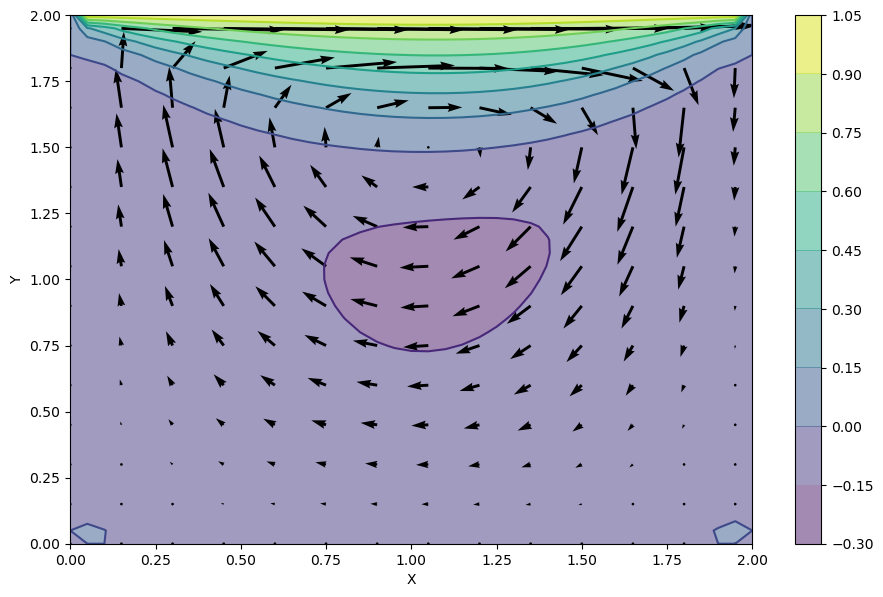

In [10]:
fig = plt.figure(figsize=(11,7),dpi=100)
plt.contourf(x,y,u[:,:],alpha=0.5,cmap=cm.viridis)
plt.colorbar()
plt.contour(x,y,u[:,:],cmap=cm.viridis)
plt.quiver(x[::3,::3],y[::3,::3],u[::3,::3],v[::3,::3])
plt.xlabel('X')
plt.ylabel('Y')


In [14]:
x

array([[0.  , 0.05, 0.1 , ..., 1.9 , 1.95, 2.  ],
       [0.  , 0.05, 0.1 , ..., 1.9 , 1.95, 2.  ],
       [0.  , 0.05, 0.1 , ..., 1.9 , 1.95, 2.  ],
       ...,
       [0.  , 0.05, 0.1 , ..., 1.9 , 1.95, 2.  ],
       [0.  , 0.05, 0.1 , ..., 1.9 , 1.95, 2.  ],
       [0.  , 0.05, 0.1 , ..., 1.9 , 1.95, 2.  ]])

In [15]:
y

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.1 , 0.1 , 0.1 , ..., 0.1 , 0.1 , 0.1 ],
       ...,
       [1.9 , 1.9 , 1.9 , ..., 1.9 , 1.9 , 1.9 ],
       [1.95, 1.95, 1.95, ..., 1.95, 1.95, 1.95],
       [2.  , 2.  , 2.  , ..., 2.  , 2.  , 2.  ]])

In [ ]:
vis